
<h1 style="text-align: center;">Trabajo Práctico Nº 4</h1>

In [2]:
import cv2
import matplotlib.pyplot as plt
import os 
import numpy as np

## Ejercicio 1

¿Qué hace la Transformada de Hough y cuáles son sus pasos?
La Transformada de Hough permite detectar líneas rectas en una imagen, transformando el problema de detectar alineaciones de píxeles en el espacio imagen a detectar acumulaciones en el espacio de parámetros 
(
𝜌
,
𝜃
)
(ρ,θ).
Los pasos que seguimos, según el enfoque teórico indicado por la cátedra, son:

1. Hallar los bordes de la imagen utilizando un método de detección de bordes.
2. Umbralizar para obtener una imagen binaria.
3. Subdividir el plano 
(
𝜌
,
𝜃
)
(ρ,θ) discretizando en una cantidad específica de puntos.

4. Para cada píxel blanco de la imagen, decidir si cumple la ecuación normal de la recta. En caso afirmativo, aumentar el acumulador.
5. Examinar el contenido de las celdas del acumulador con altas concentraciones (máximo o umbral).
6. Graficar las rectas encontradas.

libpng warning: iCCP: known incorrect sRGB profile


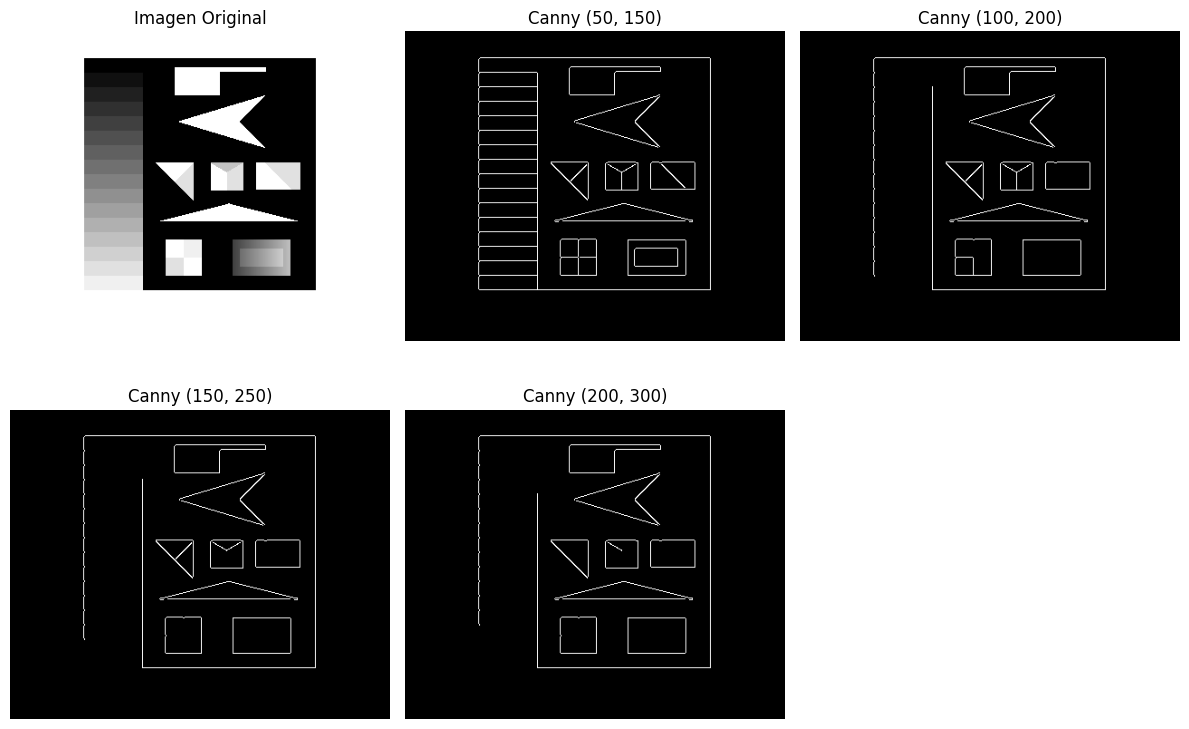

In [ ]:
# Cargar imagen en escala de grises
imagen = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)

# Verificamos que la imagen se haya cargado correctamente
if imagen is None:
    raise FileNotFoundError("No se encontró la imagen 'Test.png'.")

# Umbrales de prueba para Canny
parametros_canny = [
    (50, 150),
    (100, 200),
    (150, 250),
    (200, 300),
]

# Crear figura para mostrar los resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Imagen Original")
plt.imshow(imagen, cmap='gray')
plt.axis('off')

# Aplicar y mostrar Canny con distintos umbrales
for i, (umbral_min, umbral_max) in enumerate(parametros_canny):
    bordes = cv2.Canny(imagen, umbral_min, umbral_max)
    plt.subplot(2, 3, i + 2)
    plt.title(f'Canny ({umbral_min}, {umbral_max})')
    plt.imshow(bordes, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Detección de bordes previa con Canny
Para que la Transformada de Hough funcione correctamente, es fundamental contar con una imagen que contenga solo los bordes relevantes. Para ello, utilizamos el detector de bordes de Canny, tal como lo habíamos trabajado en el TP3.
Probamos distintos valores de umbrales y evaluamos los resultados visualmente.

Tras comparar los resultados, observamos que el par de umbrales (50,150) fue el que permitió preservar más bordes, incluyendo detalles finos.
Con ese resultado aplicamos la Transformada de Hough clásica, que detecta líneas infinitas representadas por sus parámetros 
(
𝜌
,
𝜃
)
(ρ,θ). Las líneas detectadas se graficaron sobre la imagen original.

libpng warning: iCCP: known incorrect sRGB profile


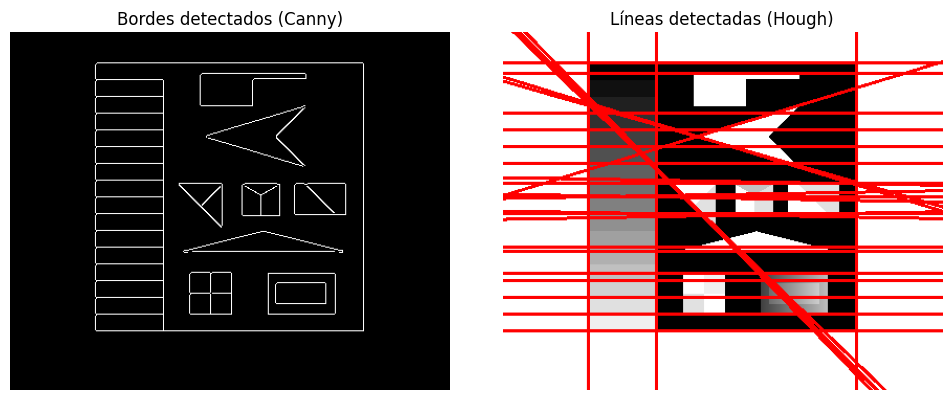

In [16]:
# 1. Cargar imagen en escala de grises
img = cv2.imread('test.png')  # Asegurate de que la imagen esté en el mismo directorio
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Detección de bordes con Canny
edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)

# Mostrar bordes detectados
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Bordes detectados (Canny)')
plt.axis('off')

# 3. Aplicar Transformada de Hough
# rho = 1 pixel, theta = 1 grado (en radianes), threshold = mínimo de votos
lines = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=70)

# 4. Dibujar líneas detectadas sobre la imagen original
img_lines = img.copy()

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # Calculamos dos puntos grandes para que la línea se extienda sobre la imagen
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

# 5. Mostrar imagen con líneas detectadas
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
plt.title('Líneas detectadas (Hough)')
plt.axis('off')

plt.tight_layout()
plt.show()


Luego, aplicamos la versión probabilística cv2.HoughLinesP, que en lugar de representar líneas infinitas, devuelve segmentos de línea concretos definidos por sus puntos extremos 
(
𝑥
1
,
𝑦
1
)
(x 
1
​
 ,y 
1
​
 ) y 
(
𝑥
2
,
𝑦
2
)
(x 
2
​
 ,y 
2
​
 ).
Esta versión permite trabajar con líneas más cortas o interrumpidas, y tiene parámetros adicionales como:

minLineLength: longitud mínima para considerar una línea.

maxLineGap: separación máxima para unir dos puntos en una misma línea.

libpng warning: iCCP: known incorrect sRGB profile


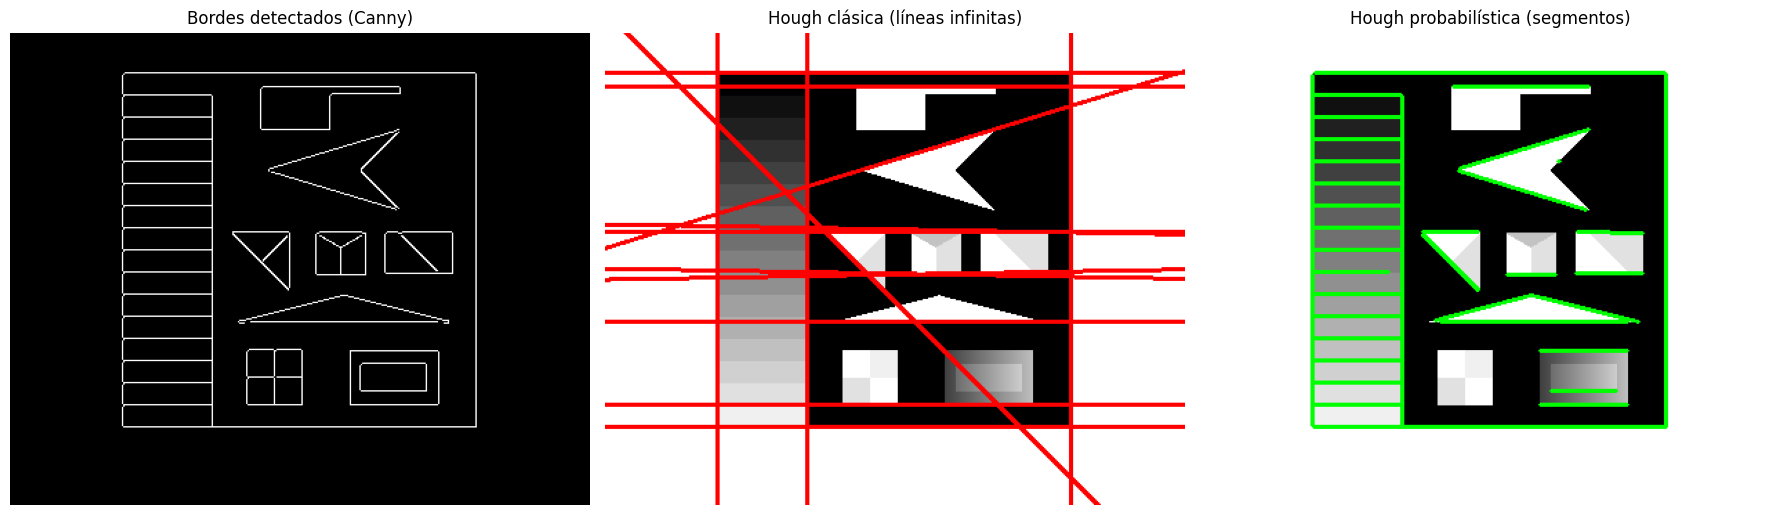

In [31]:
# 1. Cargar imagen y convertir a escala de grises
img = cv2.imread('test.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Detección de bordes con Canny
edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)

# 3A. Transformada de Hough clásica (líneas infinitas)
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=80)
img_hough = img.copy()
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img_hough, (x1, y1), (x2, y2), (0, 0, 255), 2)  # rojo

# 3B. Transformada de Hough probabilística (segmentos finitos)
lines_p = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50,
                          minLineLength=1, maxLineGap=5)
img_hough_p = img.copy()
if lines_p is not None:
    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_hough_p, (x1, y1), (x2, y2), (0, 255, 0), 2)  # verde

# 4. Mostrar resultados
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Bordes detectados (Canny)')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Hough clásica (líneas infinitas)')
plt.imshow(cv2.cvtColor(img_hough, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Hough probabilística (segmentos)')
plt.imshow(cv2.cvtColor(img_hough_p, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


Probamos diferentes combinaciones de parámetros (umbral, longitud mínima, separación máxima) para ambas versiones de Hough con el objetivo de detectar la mayor cantidad de líneas posibles.

Como conclusión, la versión probabilística resultó más detallada y realista, permitiendo representar segmentos individuales de los objetos.
Sin embargo, notamos un problema recurrente en ambos métodos: ninguno fue capaz de detectar (sin poner threshold que contaminaran demasiado la imagen) correctamente los cuadrados pequeños de la zona inferior izquierda de la imagen, ni la primera forma geometrica de margen superior. Tampoco se observa que hayan detectado el cuadrado del medio de la imagen
Este fallo puede deberse a que los lados de esos cuadrados son muy cortos, están demasiado juntos, o la detección de bordes previa no los separó bien, lo cual limita la acumulación de votos o la unión en segmentos.

<hr>
<p style="text-align: center;">
Nombre: <strong>Sosa Suarez Santiago</strong><br>
Materia: <em>Análisis y Tratamiento de Imágenes Satelitales</em><br>
Maestría en Ciencia de Datos – <em>ITBA</em><br>
Fecha: 05 de Julio de 2025
</p>
<hr>